Loading the Libraries & Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb

import torch 
import torch.nn as nn
import torch.utils.data as td


jena_df = pd.read_csv("jena_climate_2009_2016.csv")

jena_df = jena_df.rename(columns={"Date Time": "DateTime", "p (mbar)": "Pressure", "T (degC)": "TempCelsius", "Tpot (K)": "TempKelvin", "Tdew (degC)": "TempDewCelsius",
                        "rh (%)": "RelativeHumidity", "VPmax (mbar)": "SatVapourPress", "VPact (mbar)": "VapourPressure", "VPdef (mbar)": "VapPressDeficit",
                        "sh (g/kg)": "SpecificHumidity", "H2OC (mmol/mol)": "WaterVapConc", "rho (g/m**3)": "AirDensity", "wv (m/s)": "WindSpeed",
                        "max. wv (m/s)": "MaxWindSpeed", "wd (deg)": "WindDirDegrees"})

__Data Preprocessing__

All these steps are explained in the data cleaning sheet and combined here in one cell for fast processing of the data.

In [2]:
jena_df = jena_df[5::6]


jena_df['WindSpeed'].replace(-9999, 0, inplace = True)
jena_df['MaxWindSpeed'].replace(-9999, 0, inplace = True)


def out_treat(var):
    Q1 = np.quantile(var.dropna(), 0.25)
    Q3 = np.quantile(var.dropna(), 0.75)
    IQR = Q3-Q1
    LC = Q1 - (3 * IQR)
    UC = Q3 + (3 * IQR)
    var[var > UC] = UC
    var[var < LC] = LC
    return (var)
jena_df = jena_df[~jena_df.index.duplicated()]

jena_df.Pressure = out_treat(jena_df.Pressure)
jena_df.SatVapourPress = out_treat(jena_df.SatVapourPress)
jena_df.VapPressDeficit = out_treat(jena_df.VapPressDeficit)
jena_df.AirDensity = out_treat(jena_df.AirDensity)


wv = jena_df.pop('WindSpeed')
max_wv = jena_df.pop('MaxWindSpeed')
# Convert to radians.
wd_rad = jena_df.pop('WindDirDegrees')*np.pi / 180
# Calculate the wind x and y components.
jena_df['Wx'] = wv*np.cos(wd_rad)
jena_df['Wy'] = wv*np.sin(wd_rad)
# Calculate the max wind x and y components.
jena_df['max Wx'] = max_wv*np.cos(wd_rad)
jena_df['max Wy'] = max_wv*np.sin(wd_rad)


jena_df.drop(['TempCelsius'],axis=1,inplace=True)
jena_df.drop(['VapourPressure'],axis=1,inplace=True)
jena_df.drop(['WaterVapConc'],axis=1,inplace=True)


jena_df.set_index('DateTime',inplace=True, drop=True)


data = jena_df
X = data.drop(columns=["TempKelvin"],axis=1)
y = data["TempKelvin"]
#Splitting
x_train, x_test, y_train, y_test = train_test_split(X.values,y.values, test_size=0.2, shuffle=False)

#Scaling - Fit and Transform
min_max_scaler_x = MinMaxScaler()
x_train_sc = min_max_scaler_x.fit_transform(x_train)
x_test_sc = min_max_scaler_x.transform(x_test)

min_max_scaler_y = MinMaxScaler()
y_train_sc = min_max_scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_sc = min_max_scaler_y.transform(y_test.reshape(-1,1))


#training data
xtrain_tensor = torch.tensor(x_train_sc).float()
ytrain_tensor = torch.tensor(y_train_sc).float()
tensor_trainD = td.TensorDataset(xtrain_tensor, ytrain_tensor)
train_df = td.DataLoader(tensor_trainD, batch_size = round(len(xtrain_tensor)/10), shuffle = True)

#testing data
xtest_tensor = torch.tensor(x_test_sc).float()
ytest_tensor = torch.tensor(y_test_sc).float()
tensor_testD = td.TensorDataset(xtest_tensor, ytest_tensor)
test_df = td.DataLoader(tensor_testD, batch_size = len(xtest_tensor))

Checking if GPU available, then using it!

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()
host = torch.device('cpu')
print(host)

cpu
cpu


#Supervised Learning: Feed Forward
Network Structure

In [4]:
class FF(nn.Module):

  def __init__(self, input_dim, first_hidden_dim, second_hidden_dim, output_dim):
    super(FF, self).__init__()

    self.hidden1 = nn.Linear(input_dim, first_hidden_dim)
    self.sigmoid = nn.Sigmoid()
    self.hidden2 = nn.Linear(first_hidden_dim, second_hidden_dim)
    self.output = nn.Linear(second_hidden_dim, 1)
  
  def forward(self, every_batch):

    every_batch = self.hidden1(every_batch)
    every_batch = self.sigmoid(every_batch)
    every_batch = self.hidden2(every_batch)
    every_batch = self.sigmoid(every_batch)
    every_batch = self.output(every_batch)

    return every_batch

Defining the Model

It was observed that increasing hidden layers in the the structure of the network after 2 hidden layers does not improve the performance of the model. We also tuned the hidden units for each hidden layer in the network, while input dim remains constant as 11 and output dim remains constant as 1 (forecasted temperature value).

In [5]:
input_dim = 11
first_hidden_dim = 32
second_hidden_dim = 8
output_dim = 1
num_epochs = 30

Running the Model

In [6]:
collect_MSE_sample = []

for i in range(30):
    from IPython.display import clear_output
    clear_output(wait=True)
    print("Iteration: ", i+1)


    model = FF(input_dim=input_dim, first_hidden_dim=first_hidden_dim, second_hidden_dim = second_hidden_dim,
            output_dim=output_dim)
    model.to(device)

    criterion = torch.nn.MSELoss(reduction='mean') #calculating the loss
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01) #adam optimiser with learning rate of 0.01

    #defining a function for test data
    def validation(model):
        with torch.no_grad():
            for input, target in test_df:       
                y_test_pred = model(input.to(device))
                test_loss = criterion(y_test_pred, target.to(device))
        return test_loss.item(), y_test_pred

    #training over the number of epochs
    import time #to measure the time taken by model to run
    training_losses = np.zeros(num_epochs)
    testing_losses = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
        for input, target in train_df:       
            y_train_pred = model(input.to(device)) #predicted values of train data
            train_loss = criterion(y_train_pred, target.to(device)) #calculate train loss

            optimiser.zero_grad() #making the gradients zero
            train_loss.backward() #backpropogating through the network by changing weights
            optimiser.step()
            
        training_losses[t] = train_loss.item()
        testing_losses[t] = validation(model)[0]

        print("Epoch ", t, "Train MSE: ", train_loss.item(), "Test MSE: ", validation(model)[0])


    collect_MSE_sample.append(testing_losses[num_epochs-1])     
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))

Iteration:  30
Epoch  0 Train MSE:  0.003597532631829381 Test MSE:  0.01925891824066639
Epoch  1 Train MSE:  0.012413240037858486 Test MSE:  0.022268977016210556
Epoch  2 Train MSE:  0.08742091059684753 Test MSE:  0.018282094970345497
Epoch  3 Train MSE:  0.01495545543730259 Test MSE:  0.0174789447337389
Epoch  4 Train MSE:  0.0017075756331905723 Test MSE:  0.015195322223007679
Epoch  5 Train MSE:  0.008091434836387634 Test MSE:  0.01374866720288992
Epoch  6 Train MSE:  0.02596583589911461 Test MSE:  0.010808279737830162
Epoch  7 Train MSE:  0.0339239202439785 Test MSE:  0.0066488212905824184
Epoch  8 Train MSE:  0.0011644730111584067 Test MSE:  0.0023001651279628277
Epoch  9 Train MSE:  0.0001767773792380467 Test MSE:  0.0006670689326710999
Epoch  10 Train MSE:  0.0003125584917142987 Test MSE:  0.0006169122061692178
Epoch  11 Train MSE:  6.448661588365212e-05 Test MSE:  0.0005281076882965863
Epoch  12 Train MSE:  0.0001583950943313539 Test MSE:  0.00034782433067448437
Epoch  13 Train 

In [7]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('#Points to Note:')
printmd(f"##1. Epochs Taken: {num_epochs}")
printmd(f"##2. Time Taken: {round(training_time)} seconds")
printmd(f"##3. testMSE_mean (30 samples): {round(np.mean(collect_MSE_sample), 6)}")
printmd(f"##3. testMSE_SD (30 samples): {round(np.std(collect_MSE_sample), 6)}")

#Points to Note:

##1. Epochs Taken: 30

##2. Time Taken: 29 seconds

##3. testMSE_mean (30 samples): 0.000326

##3. testMSE_SD (30 samples): 0.000188

Making predictions over test data

In [8]:
#predicted test data values
predict = pd.DataFrame(min_max_scaler_y.inverse_transform(validation(model)[1].to(host).detach().numpy()))
predict = predict.rename(columns={0: "Predicted"})
#original test data labels
original = pd.DataFrame(min_max_scaler_y.inverse_transform(ytest_tensor.detach().numpy()))
original = original.rename(columns={0: "Original"})

result = pd.concat([original, predict], axis=1, join='inner')
result.head(5)

,Original,Predicted
0,291.929993,292.503418
1,290.930023,291.542786
2,289.799988,290.423492
3,289.009979,289.611847
4,288.139984,288.680054


Plotting training and testing losses

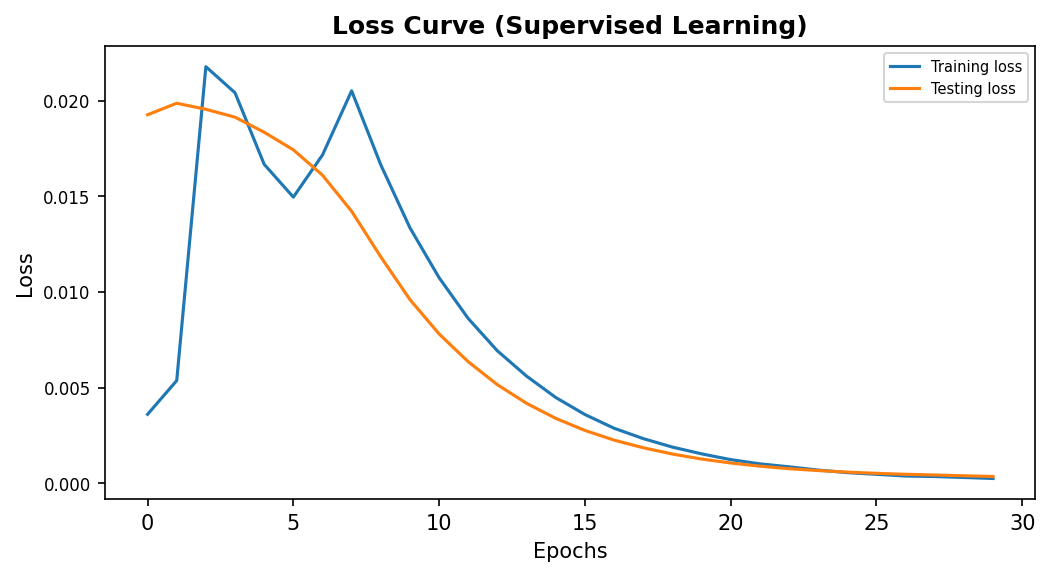

In [9]:
def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points


# plotting the training and validation loss
plt.figure(figsize=(8,4),dpi=150)
plt.plot(smooth_curve(training_losses), label='Training loss')
plt.plot(smooth_curve(testing_losses), label='Testing loss')
plt.title('Loss Curve (Supervised Learning)',fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.yticks(size=8)
plt.legend(prop={'size': 7})
plt.show()

Plotting predicted values against actual values

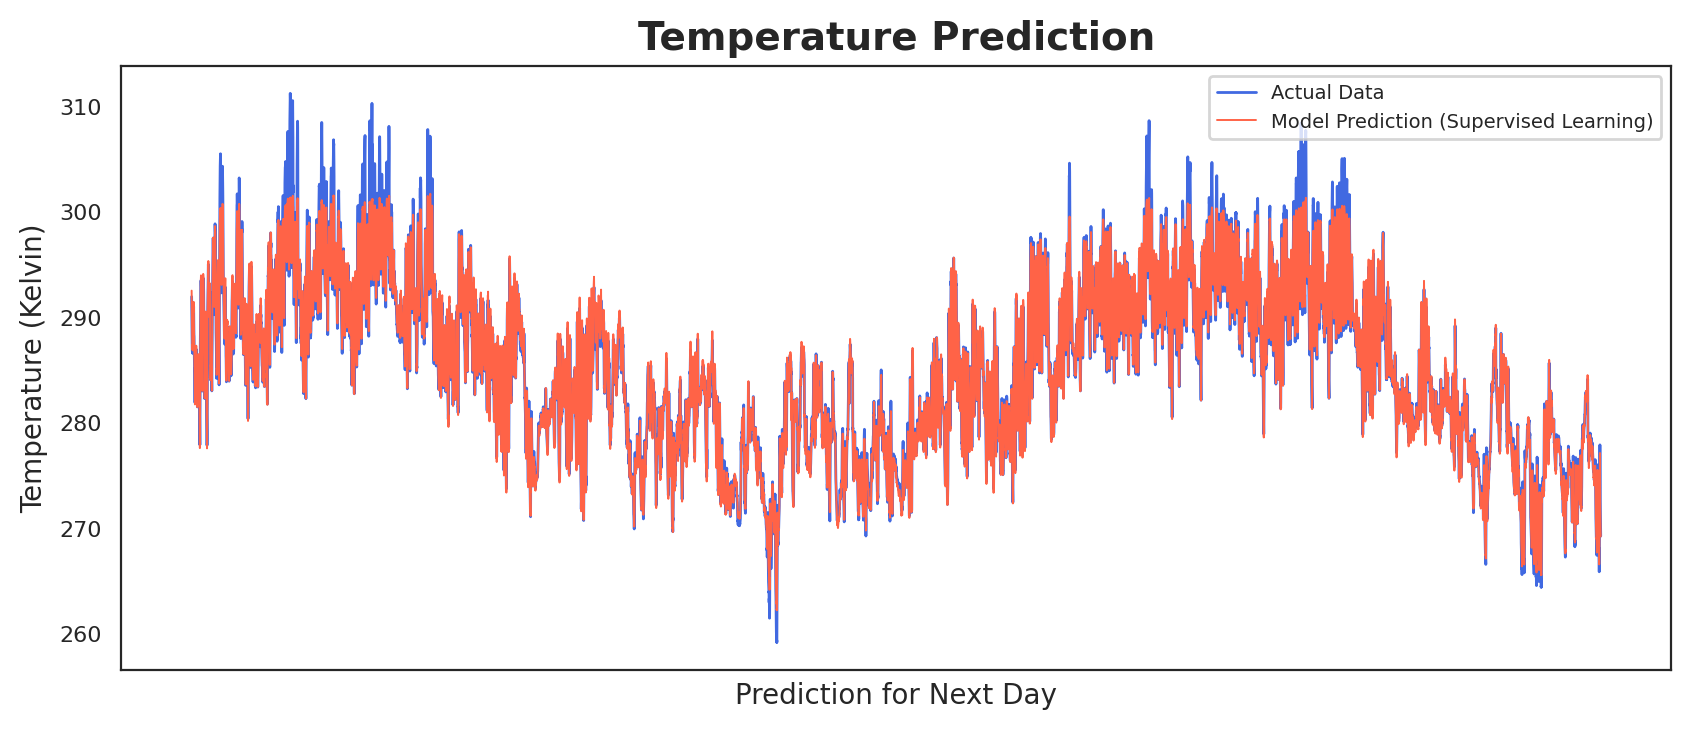

In [10]:
plt.figure(figsize = (10,4), dpi=200)
sb.set_style("white")    

sb.lineplot(x = original.index, y = original["Original"], label="Actual Data", color='royalblue',linewidth=1)
sb.lineplot(x = predict.index, y = predict["Predicted"], label="Model Prediction (Supervised Learning)", color='tomato',linewidth=0.7)
plt.title('Temperature Prediction', size = 14, fontweight='bold')
plt.xlabel("Prediction for Next Day", size = 10)
plt.ylabel("Temperature (Kelvin)", size = 10)
plt.xticks(ticks=[])
plt.yticks(size=8)
plt.legend(loc="upper right", prop={'size': 7})
plt.show()